# 实验数据准备（周四上课前完成）

### 安装spikingjelly，帮助我们读取数据

```bash

python3 -m pip install spikingjelly

```

### 这段数据处理的代码第一次要跑30min左右，需要几GB的硬盘空间

首先下载数据：

https://cloud.tsinghua.edu.cn/d/be1af14046894bc0b8dd/

在notebook路径新建data文件夹，在data文件夹中新建download文件夹
把这两个zip包拷贝进去

In [1]:
from spikingjelly.datasets.n_mnist import NMNIST
from torch.utils.data import DataLoader

# 初始化数据加载器
data_dir = '.\\data'
# !mkdir .\\data
# !mkdir .\\data\\download

T = 10  #整段视频数据分为20帧输入
batch_size = 64  #批大小为64
train_set = NMNIST(data_dir, train=True, data_type='frame', split_by='number', frames_number=T)
test_set = NMNIST(data_dir, train=False, data_type='frame', split_by='number', frames_number=T)

train_data_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True)

test_data_loader = DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    pin_memory=True)


The directory [.\data\frames_number_10_split_by_number] already exists.
The directory [.\data\frames_number_10_split_by_number] already exists.


# LIF

LIF神经元（Leaky Integrate-and-Fire neuron）是一种简化的神经元模型，常用于计算神经科学和计算机科学中的仿真研究。

LIF神经元模型假设神经元的动作电位通过漏电流逐渐增加并在达到阈值时触发，从而产生脉冲输出。

### LIF神经元模型的主要特点包括

1. 积分：神经元对输入的电流进行累积。每个神经元都有一个内部电位，称为膜电位，该电位会随着时间不断增加。当膜电位达到一定阈值时，神经元将产生一个输出脉冲。 

2. 漏电：LIF神经元模型假设存在一个漏电流，它导致膜电位趋于恢复至基准电位。这意味着即使没有输入激活，膜电位也会逐渐减少。 

3. 阈值触发：当膜电位达到设定的阈值时，神经元将产生一个输出脉冲。在脉冲发放之后，膜电位会被重置为初始电位并开始重新积分。


### LIF神经元的功能

LIF神经元模型的简单性使得它成为计算神经科学中常用的模型之一。它可以用于模拟神经元网络的活动，研究神经元之间的连接和信息传递。
此外，LIF神经元也常用于神经网络的计算模拟中，用于解决机器学习和模式识别等问题。

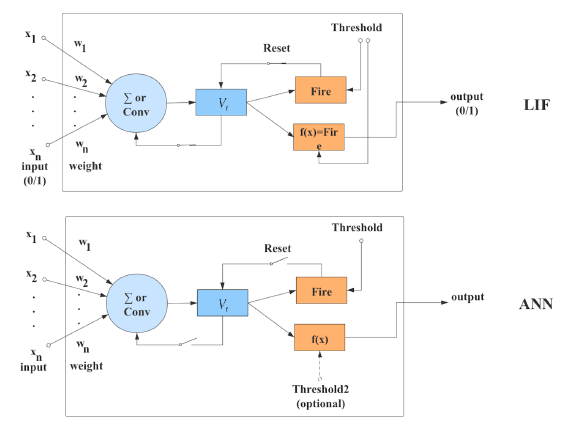
Fig. 1 | 用于可学习的脉冲神经网络中的LIF神经元结构

本文参考代码：[LIAF-SNN代码实现](https://github.com/lyh983012/SNN-genunit/blob/main/LIAF.py)

In [2]:
%load_ext autoreload

# 导入包

In [3]:
%autoreload
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

# (1) 实现LIF神经元的迭代机制

### 离散化之前

IF部分由下列ODE描述，本质上是个RC放电过程

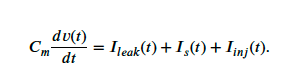

其中𝐶𝑚 是膜电容，𝑣 是膜电位，𝐼_𝑙𝑒𝑎𝑘 是泄漏电流（从动作电位回归静息电
位时起主要作用），𝐼_𝑠 是和胞体相连的突触的输入，𝐼_𝑖𝑛𝑗 是注入电流。

其中 

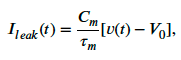


把所有的电流项都合并为I,可以获得简化版的方程

$$\tau \frac{du}{dt} = -u + x $$

这就是个指数衰减的电压信号

Leaky过程是为了简化HH的重置过程

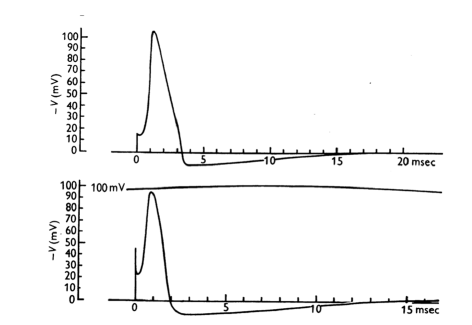

LIF中就直接把这个变成一个阈值重置过程

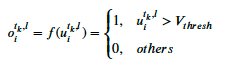


### 离散化之后
记号：V为膜电位，S为脉冲，X为输入，W为权重，\tau是时间常数

$$ V'[t] = V[t-1] + W*X[n] $$
$$ S[t] = spikefun(V'[t])       $$
$$ V[t] = V'[t] * (1-S[t]) * \tau   $$

下面我们按这个离散化形式来手搓一个LIF模型

**任务1：补全膜电位发放代码**

In [4]:
#简单的阈值发放
def trivalSpikeAct(input_mem:torch.tensor, threshold: float):
    return torch.gt(input_mem,threshold).float()

input_data = torch.randn([5])
print('test SpikeAct:',input_data,'-->',trivalSpikeAct(input_data,threshold=0.1))


# 时间常数decay如果可训练，不要让它带来正反馈放大
def norm_decay(decay):
    # 其实还应该避免一下负值
    return torch.sigmoid(decay)


#################################################
# 适用于1D全连接的SNN神经元组织方式
#    - 输入电流序列：[B,T,N] 或者 单个时间步上的电流 [B,1,N]
#    - 当前膜电位，若为None即从0开始
#    - 思考1：spike.detach() 为什么要加.detach()，不加可以吗?
#            detach相当于在计算图中将其之前的梯度传播断开
#
#    - 思考2：每次迭代完mem.clone()相当于新建一个一模一样，但在计算图上
#           相当于一个新节点的mem_old，意义是什么？
##################################################
def mem_update_1D(inputI,decay=0.5,thresh=0.5,init_mem=None,init_spike=None,spikeAct = trivalSpikeAct):
    '''
        @inputI:    torch.Tensor,输入电流,尺寸为[Batch,TimeLen,NeuronNumber]
        @init_mem:  torch.Tensor,初始膜电位,尺寸为[Batch,1,NeuronNumber]，没有输入时初始化为0
        @init_spike:torch.Tensor,上次脉冲（用以重置膜电位）,尺寸为[Batch,NeuronNumber]，没有输入时初始化为0
        @spikeAct:  function name,脉冲函数句柄
        
        inputI                                  #X[b,t,n]
    '''
        
    #初始化
    TimeLen = inputI.size(1)
    mem = torch.zeros_like(inputI[:,0:1,:])     #V[t]
    output = torch.zeros_like(inputI)           #S
    spike = torch.zeros_like(inputI[:,0:1,:])   #S[t]
    mem_history = []                            #V
    mem_tmp = torch.zeros_like(inputI[:,0:1,:]) #V'[t]
    if init_mem is not None:
        mem_tmp = init_mem
    if init_spike is not None:
        spike = init_spike
        
    #对timeLen长度序列的输入信号，循环迭代膜电位
    for i in range(TimeLen):
        decay = norm_decay(decay)
        #===========[your code]=============
        mem = mem_tmp * decay *(1 - spike.detach()) + inputI[:,i:i+1,:]
        #===========[end of code]=============
        mem_history.append(mem.clone())
        mem_tmp = mem.clone()
        spike = spikeAct(mem_tmp,thresh)         
        output[:,i:i+1,:] = spike
        
    #存起来
    mem_history = torch.cat(mem_history,dim=1)
    assert output.size() == inputI.size()
    assert mem_history.size(1) == TimeLen #不包含初始膜电位
    return output,mem_history

#封装一个膜电位更新的类，作为base neuron
class BaseNeuron(nn.Module):
    decay_trainable = False
    def __init__(self):
        super().__init__()
        self.fire_rate = 0  #存脉冲发放率，方便知道神经元的工作状态
        self.thresh =  0.5  #阈值大小
        self.decay =torch.nn.Parameter(torch.ones(1) * 0.5, requires_grad=BaseNeuron.decay_trainable)
        # 时间常数，设置为parameter，可以变为可训练参数

    def forward(self,input):
        # 在pytorch中前向推理所需
        raise NotImplementedError("Input neurons must implement `base_neuron_forward`")

    def memUpdate(self,inputI,init_mem=None,init_spike=None,spikeAct = trivalSpikeAct):
        if len(inputI.shape)==3:
            return mem_update_1D(inputI,self.decay,self.thresh,init_mem,init_spike,spikeAct)
        if len(inputI.shape)==5:
            return mem_update_3D(inputI,self.decay,self.thresh,init_mem,init_spike,spikeAct)

test SpikeAct: tensor([-0.0485, -1.9866, -0.9839, -0.3715,  0.9881]) --> tensor([0., 0., 0., 0., 1.])


# 看看例子

用法示例1:范式1，逐层传递


C:\Users\qhlzy\AppData\Local\Temp\ipykernel_22576\3707104412.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,1)


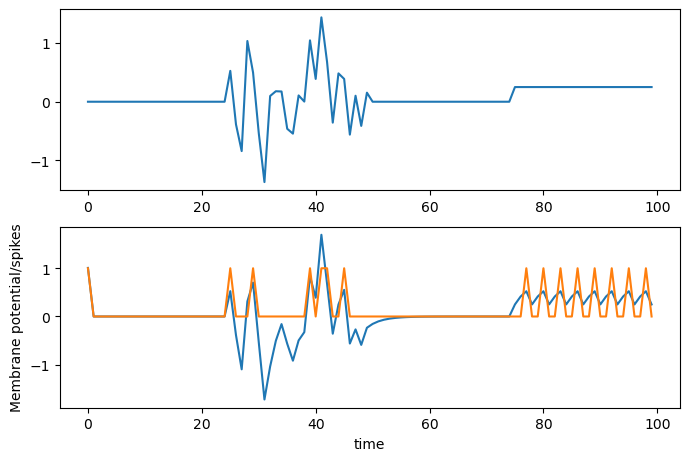

C:\Users\qhlzy\AppData\Local\Temp\ipykernel_22576\3707104412.py:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,1)


用法示例2:范式2 按时间传递


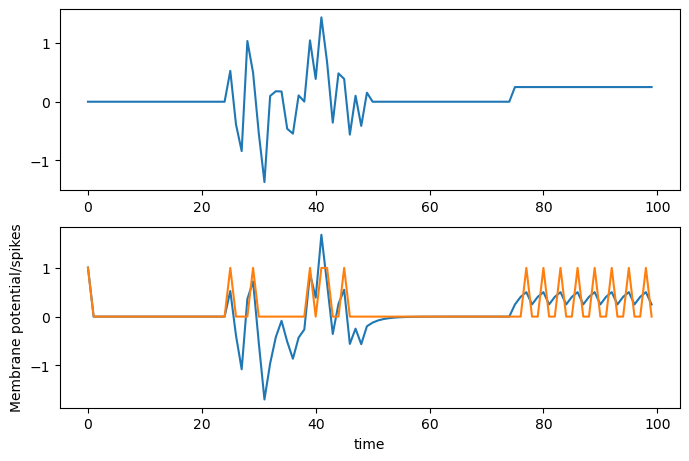

In [5]:
myFirstNeuron = BaseNeuron()

print("用法示例1:范式1，逐层传递")
T = 100
inputSpikes = torch.randn([1,T,1])/1.5 #一个长为T，维度为1（1个神经元）的输入序列
inputSpikes[0,0:T//4,0] = 0
inputSpikes[0,T//2:T*3//4,0] = 0
inputSpikes[0,3*T//4:,0] = 1/4
init_mem = torch.randn([1,1,1])#一个长为1，维度为1（1个神经元）的初始膜电位
outputSpikes,mem_history = myFirstNeuron.memUpdate(inputI=inputSpikes,init_mem=init_mem)

plt.figure(figsize=(8,8))
plt.ylabel("Current")
plt.subplot(3,1,1)
plt.plot(inputSpikes[0,:,0])
plt.subplot(3,1,2)
plt.ylabel("Membrane potential/spikes")
plt.plot(mem_history[0,:,0])
plt.plot(outputSpikes[0,:,0])

plt.xlabel("time")
plt.show()

print("用法示例2:范式2 按时间传递")
collected_spike = []
collected_mem = []
for t in range(T): 
    input_spike_t = inputSpikes[:,t:t+1,:] #假装是每个t新得到一个输入
    if t == 0:
        #初始化
        outputSpikes,mem_history = myFirstNeuron.memUpdate(inputI=input_spike_t,
                                                               init_mem=init_mem,
                                                               init_spike=torch.zeros_like(init_mem))
    else:
        #用历史结果迭代
        outputSpikes,mem_history = myFirstNeuron.memUpdate(inputI=input_spike_t,
                                                               init_mem=mem_history,
                                                               init_spike=outputSpikes)
    collected_mem.append(mem_history)
    collected_spike.append(outputSpikes)

collected_mem = torch.cat(collected_mem,dim=1)
collected_spike = torch.cat(collected_spike,dim=1)   
plt.figure(figsize=(8,8))
plt.ylabel("Current")
plt.subplot(3,1,1)
plt.plot(inputSpikes[0,:,0])
plt.subplot(3,1,2)
plt.ylabel("Membrane potential/spikes")
plt.plot(collected_mem[0,:,0])
plt.plot(collected_spike[0,:,0])
plt.xlabel("time")
plt.show()

# (2) 1D-LIF神经元的实现

### 把权重连接加入baseNeuron，获得可以构造复杂神经元网络的FC_LIF_neuron

时间常数的训练并不能给神经网络增强过多的空间表达能力

ANN的设计经验告诉我们加权输入上的权重参数是空间表达能力的核心

因此在网络的forward部分，需要加入:

$$ X_n --> W * X_n $$


**任务2：补全全连接加权代码**

In [6]:
#继承BaseNeuron类
class LIFLayer(BaseNeuron):
    def __init__(self,inputSize,hiddenSize):
        '''
        @param input_size: (Num) number of input
        @param hidden_size: (Num) number of output
        @param dropout: 0~1
        '''
        super().__init__()
        self.inputSize = inputSize              
        self.hiddenSize = hiddenSize        
        self.kernel=nn.Linear(inputSize, hiddenSize)  #输入权重
        self.NormLayer = nn.BatchNorm1d(hiddenSize)   #批归一化层
        dropOut = 0.1
        self.DPLayer = nn.Dropout(dropOut)             

    def forward(self,inputData,init_mem=None,spikeAct = trivalSpikeAct):
        """
        @param input: a tensor of of shape (Batch, time, insize)
        @param init_v: a tensor with size of (Batch, time, outsize) denoting the mambrane v.
        """
        #step 0: init
        self.device = self.kernel.weight.device
        if inputData.device != self.device:
            inputData = inputData.to(self.device)
        self.batchSize = inputData.size(0)
        self.timeLens = inputData.size(1)
        synaptic_input = torch.zeros(self.batchSize,self.timeLens,self.hiddenSize,device=self.device)
        
        #===========[your code]=============
        for time in range(self.timeLens):
            #逐帧加权处理输入
            synaptic_input[:,time,:] = self.kernel(inputData[:,time,:])
        #===========[end of code]=============

            
        synaptic_input = self.NormLayer(synaptic_input.permute(0,2,1)).permute(0,2,1)
        #丢掉一部分输入
        synaptic_input = self.DPLayer(synaptic_input)
        #迭代膜电位产生脉冲
        
        outputSpikes,mem_history = self.memUpdate(synaptic_input,init_mem=init_mem, spikeAct=spikeAct)
        return outputSpikes,mem_history
    


# (2.1) LIF-SNN的可训练性？

这样是否就可以训练了呢？
让我们来测试一下

In [7]:
myLiFLayer = LIFLayer(728,256)

print("用法示例1:整个batch的输入都准备好")
T = 20
inputSpikes = torch.randn([1,T,728])/1.5 #一个长为T，维度为1（1个神经元）的输入序列
inputSpikes[0,0:T//4,0] = 0
inputSpikes[0,T//2:T*3//4,0] = 0
inputSpikes[0,3*T//4:,0] = 1/4

labelSpiles = torch.randn([1,T,256])/1.5
outputSpikes,mem_history = myLiFLayer(inputSpikes)

loss_fun = torch.nn.MSELoss()

try:
    loss = loss_fun(labelSpiles,outputSpikes)
    loss.backward()
except RuntimeError as e:
    print('sth wrong:',e)

用法示例1:整个batch的输入都准备好
sth wrong: element 0 of tensors does not require grad and does not have a grad_fn


# 如何解决？

torch.gt()不是一个可微分的函数。因此SNN很长一段时间没有人尝试过用BPTT的方式做训练

直到pytorch出现，[STBP]()这篇文章将激活函数找到了一个梯度近似的方案，迈出了以第一步

In [8]:
#######################################################
# activation
# LIFactFun : approximation firing function
# For 2 value-quantified approximation of δ(x)
# LIF激活函数
# 复现的STBP论文中的激活函数
#######################################################    

class LIFactFun(torch.autograd.Function):
    lens = 0.5      # LIF激活函数的梯度近似参数，越小则梯度激活区域越窄
    bias = -0.2     # 多阈值激活函数的值域平移参数                            
    sigma = 1       # 高斯梯度近似时的sigma
    use_rect_approx = False # 选择方梯度近似方法【Switch Flag】
    use_gause_approx = True # 选择高斯梯度近似方法【Switch Flag】
    def __init__(self):
        super(LIFactFun, self).__init__()

    # 阈值激活，带有输入阈值，阈值可训练
    @staticmethod
    def forward(ctx, input, thresh=0.5):
        fire = input.gt(thresh).float() 
        ctx.save_for_backward(input)
        ctx.thresh = thresh
        return fire 

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = 0
        thresh = ctx.thresh
        if LIFactFun.use_rect_approx:
            temp = abs(input - thresh) < LIFactFun.lens  
            grad = grad_input*temp.float()/(2*LIFactFun.lens)
        elif LIFactFun.use_gause_approx:
            temp = 0.3989422804014327 / LIFactFun.sigma*torch.exp(-0.5/(LIFactFun.sigma**2)*(input-thresh+LIFactFun.bias)**2) 
            grad = grad_input * temp.float()
        return grad, None

In [9]:
myLiFLayer = LIFLayer(728,256)

print("用法示例1:整个batch的输入都准备好")
T = 20
inputSpikes = torch.randn([1,T,728])/1.5 #一个长为T，维度为1（1个神经元）的输入序列
inputSpikes[0,0:T//4,0] = 0
inputSpikes[0,T//2:T*3//4,0] = 0
inputSpikes[0,3*T//4:,0] = 1/4

labelSpiles = torch.randn([1,T,256])/1.5
outputSpikes,mem_history = myLiFLayer(inputSpikes,spikeAct = LIFactFun.apply)

loss_fun = torch.nn.MSELoss()

try:
    loss = loss_fun(labelSpiles,outputSpikes)
    loss.backward()
    print('gradience is succesfully backpropagated')
except RuntimeError as e:
    print('sth wrong:',e)

用法示例1:整个batch的输入都准备好
gradience is succesfully backpropagated


# (3) 3D-LIF神经元的实现

### 卷积连接这么好用，SNN也要用！

但在这之前要实现一下这个函数：mem_update_3D （此前FC中的mem_update_1D已经实现好了）

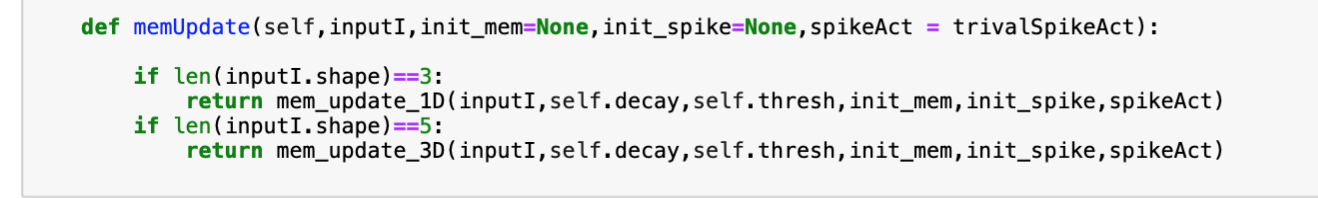


**任务3：补全3D输入的膜电位更新代码**

In [10]:
import math

################################
# 适用于2D卷积连接的SNN神经元组织方式
#    - 输入电流序列：[B,C,T,W,H] 或者 单个时间步上的电流 [B,C,1,W,H]
#           C放在第二个维度是为了方便和3DCNN的组织方式兼容
#            因此也可以用3D卷积处理脉冲序列
#    - 当前膜电位，若为None即从0开始  
#           Task1: 模仿1D，将3D的膜电位更新实现，用于卷积网络
################################
def mem_update_3D(inputI,decay=0.5,thresh=0.5,init_mem=None,init_spike=None,spikeAct = trivalSpikeAct):
    '''
        @inputI:    torch.Tensor,输入电流,尺寸为[Batch,Channel,TimeLen,Dim1,Dim2]
        @init_mem:  torch.Tensor,初始膜电位,尺寸为[Batch,Channel,1,Dim1,Dim2]，没有输入时初始化为0
        @init_spike:torch.Tensor,上次脉冲（用以重置膜电位）,尺寸为[Batch,Channel,1,Dim1,Dim2]，没有输入时初始化为0
        @spikeAct:  function name,脉冲函数句柄
    '''
        
    #初始化
    TimeLen = inputI.size(2)
    mem = torch.zeros_like(inputI[:,:,0:1,...])
    output = torch.zeros_like(inputI) 
    spike = torch.zeros_like(inputI[:,:,0:1,...])
    mem_history = []
    mem_old = torch.zeros_like(inputI[:,:,0:1,...])
    
    if init_mem is not None:
        mem_old = init_mem
    if init_spike is not None:
        spike = init_spike

    #模仿1D-LIF
    
    for i in range(TimeLen):
    #===========[your code]=============   
        decay = norm_decay(decay)
        mem = mem_old * decay *(1 - spike) + inputI[:,:,i:i+1,...]
        mem_old = mem.clone()
        spike = spikeAct(mem_old,thresh) 
        output[:,:,i:i+1,...] = spike
    #===========[end of code]=============
        mem_history.append(mem.clone())
    
    
    #存起来
    mem_history = torch.cat(mem_history,dim=2)
    assert output.size() == inputI.size()
    assert mem_history.size(2) == TimeLen #不包含初始膜电位
    return output,mem_history


#继承BaseNeuron类
class LIF_2D_Layer(BaseNeuron):
    def __init__(self,inChannels,
                     outChannels,
                     kernelSize,
                     stride,
                     padding =0):
        '''
        @param input_size: (Num) number of input
        @param hidden_size: (Num) number of output
        @param dropout: 0~1
        '''
        super().__init__()      
        self.padding = padding
        self.stride = stride
        self.kernelSize = kernelSize
        self.inChannels = inChannels
        self.oc = outChannels
        self.kernel = nn.Conv2d(inChannels,
                                self.oc,
                                self.kernelSize,
                                stride=self.stride,
                                padding= self.padding,
                                bias=True,
                                padding_mode='zeros')
        self.NormLayer = nn.BatchNorm3d(outChannels)   #批归一化层--->为什么我们把T不放在第二个维度
        self.firstPrint = True
        
    def forward(self,inputData,init_mem=None,spikeAct = trivalSpikeAct):
        """
        @param input: a tensor of of shape (Batch, time, insize)
        @param init_v: a tensor with size of (Batch, time, outsize) denoting the mambrane v.
        """
        #step 0: init
        self.device = self.kernel.weight.device
        if inputData.device != self.device:
            inputData = inputData.to(self.device)
        self.bs = inputData.size(0)
        self.tl = inputData.size(2)

        synaptic_input = []
        #逐帧加权处理输入
        #另一种写法：用list存储后再把tensor拼接起来，效率较低
        for time in range(self.tl):
            synaptic_input.append(self.kernel(inputData[:,:,time,...]))
        synaptic_input = torch.stack(synaptic_input,dim=2).to(self.device)
        synaptic_input = self.NormLayer(synaptic_input)
        
        if self.firstPrint:
            self.firstPrint=False
            print('这层输出大小:',synaptic_input.shape)

        #迭代膜电位产生脉冲
        outputSpikes,mem_history = self.memUpdate(synaptic_input,init_mem=init_mem, spikeAct=spikeAct)
        
        return outputSpikes,mem_history
    
    
my_first_2Dlayer = LIF_2D_Layer(3,64,3,2,1)
spikeTensor = torch.randn([1,3,20,28,28])#batch，channel，时间步，高，宽
outputSpikes,mem_history = my_first_2Dlayer(spikeTensor)

这层输出大小: torch.Size([1, 64, 20, 14, 14])


# (4) 训练一个LIF-SNN！

### 安装spikingjelly，帮助我们读取数据

```bash

python3 -m pip install spikingjelly

```

### 这段数据处理的代码第一次要跑30min左右，以后就秒过

In [11]:
from spikingjelly.datasets.n_mnist import NMNIST
from torch.utils.data import DataLoader

# 初始化数据加载器
data_dir = '.\\data'
# !mkdir .\\data
# !mkdir .\\data\\download

T = 10
batch_size = 64
train_set = NMNIST(data_dir, train=True, data_type='frame', split_by='number', frames_number=T)
test_set = NMNIST(data_dir, train=False, data_type='frame', split_by='number', frames_number=T)

train_data_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True)

test_data_loader = DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    pin_memory=True)


The directory [.\data\frames_number_10_split_by_number] already exists.
The directory [.\data\frames_number_10_split_by_number] already exists.


# 创建一个ConvLIF-SNN


**任务4：填充前向推理部分，并且尝试修改超参数**

In [105]:
import torch.nn.functional as F

def temporalPooling(x,kernel_size=(2,2)):
    timeLen = x.shape[2]
    pooledSpike = []
    for t in range(timeLen):
        spikeFrame = x[:,:,t,...]
        pooledSpike.append(F.max_pool2d(spikeFrame,kernel_size))
    return torch.stack(pooledSpike,dim=2).to(spikeFrame.device)

class LIF_2D_CNN(nn.Module):
    def __init__(self):
        super().__init__()  
        # 卷积层参数：输入通道、输出通道、kernel大小、卷积步长、补零尺寸
        self.lifcnn1 = LIF_2D_Layer(2,32,5,3,2)
        self.lifcnn2 = LIF_2D_Layer(32,64,5,3,2)
        self.lifcnn3 = LIF_2D_Layer(64,128,3,2,1)
        self.liffc1 = LIFLayer(128,64)
        self.liffc2 = LIFLayer(64,10)
#         self.lifcnn1 = LIF_2D_Layer(2,128,5,3,2)
#         self.lifcnn2 = LIF_2D_Layer(128,512,5,3,2)
#         self.lifcnn3 = LIF_2D_Layer(512,1024,3,2,1)
#         self.liffc1 = LIFLayer(1024,512)
#         self.liffc2 = LIFLayer(512,10)
    
    def forward(self,input_data):
        ############## your code ###########
        x, _ = self.lifcnn1(input_data, spikeAct = LIFactFun.apply)
        x, _ = self.lifcnn2(x, spikeAct = LIFactFun.apply)
        x, _ = self.lifcnn3(x, spikeAct = LIFactFun.apply)
        x = temporalPooling(x,kernel_size=x.shape[-2:])
        
        x = x.view(x.shape[0],x.shape[1],x.shape[2]).permute(0,2,1)
        x, _ = self.liffc1(x,spikeAct = LIFactFun.apply)
        x, _ = self.liffc2(x,spikeAct = LIFactFun.apply)
        x = torch.mean(x,dim=1)
        ##############    end    ###########
        return x
    
# 初始化
net = LIF_2D_CNN()
print('输出大小:',net(torch.randn([16,2,20,34,34])).shape)
print(net)

这层输出大小: torch.Size([16, 32, 20, 12, 12])
这层输出大小: torch.Size([16, 64, 20, 4, 4])
这层输出大小: torch.Size([16, 128, 20, 2, 2])
输出大小: torch.Size([16, 10])
LIF_2D_CNN(
  (lifcnn1): LIF_2D_Layer(
    (kernel): Conv2d(2, 32, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
    (NormLayer): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lifcnn2): LIF_2D_Layer(
    (kernel): Conv2d(32, 64, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
    (NormLayer): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lifcnn3): LIF_2D_Layer(
    (kernel): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (NormLayer): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (liffc1): LIFLayer(
    (kernel): Linear(in_features=128, out_features=64, bias=True)
    (NormLayer): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (DPLayer): Dropout(p=0.1, i

In [145]:
import torch

def neg_one_hot(label, len):
    neg_label_onehot = []
    label_onehot = F.one_hot(label, len).float()
    for item in label_onehot:
        neg_label_onehot.append([int(not x) for x in item.tolist()])
    return torch.tensor(neg_label_onehot).to('cuda:0')

def bin_code(label, len):
    binary_list = []
    for item in label:
        binary_str = bin(item)[2:]  # 将label转为二进制字符串（去掉前缀'0b'）
        binary_str = binary_str.zfill(len)  # 将二进制字符串填充到指定长度
        binary_list.append([int(bit) for bit in binary_str])  # 将二进制字符串转为整数列表
    return torch.tensor(binary_list).to('cuda:0')

def gray_code(label, len):
    gray_list = []
    for item in label:
        binary_str = bin(item)[2:]  # 将label转为二进制字符串（去掉前缀'0b'）
        binary_str = binary_str.zfill(len)  # 将二进制字符串填充到指定长度
        gray_str = binary_str[0] + ''.join([str(int(binary_str[i]) ^ int(binary_str[i + 1])) for i in range(len - 1)])  # 计算格雷码字符串
        gray_list.append([int(gray) for gray in gray_str])  # 将二进制字符串转为整数列表
    return torch.tensor(gray_list).to('cuda:0')

def binary_to_int(binary_list):
    decimal_value = []
    for item in binary_list:
        new_item = []
        for i in item:
            new_item.append(1 if i > 0.5 else 0)
        binary_str = ''.join(map(str, new_item))  # 将二进制列表转为字符串
        decimal_value.append(int(binary_str, 2))  # 将二进制字符串转为整数
    return torch.tensor(decimal_value).to('cuda:0')

def gray_to_int(gray_list):
    def flip_num(my_nu):
        return 1 if (my_nu == 0) else 0

    def gray_to_binary(gray_list):
        binary_list = []
        for gray in gray_list:
            binary_code = []
            binary_code.append(gray[0])
            for i in range(1, len(gray)):
                if gray[i] == 0:
                    binary_code.append(binary_code[i - 1])
                else:
                    binary_code.append(flip_num(binary_code[i - 1]))
            binary_list.append(binary_code)

        return binary_list

    binary_list = gray_to_binary(gray_list)
    decimal_value = []
    for item in binary_list:
        new_item = []
        for i in item:
            new_item.append(1 if i > 0.5 else 0)
        binary_str = ''.join(map(str, new_item))  # 将二进制列表转为字符串
        decimal_value.append(int(binary_str, 2))  # 将二进制字符串转为整数
    return torch.tensor(decimal_value).to('cuda:0')

# 训练和验证

In [149]:
import os,time
from tqdm import tqdm

device = torch.device('cuda:0')
lr = 1e-2
epochs = 3
T_max = epochs
net.to(device)
out_dir = './runs'

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

# 训练网络
start_epoch = 0
max_test_acc = 0

if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    print(f'Mkdir {out_dir}.')


for epoch in range(start_epoch, epochs):
    start_time = time.time()
    net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    count = 0
    for frame, label in tqdm(train_data_loader):
        optimizer.zero_grad()
        frame = frame.permute(0,2,1,3,4)
        frame = frame.float().to(device)
        label = label.to(device)
#         label_onehot = F.one_hot(label, 10).float()
#         label_onehot = neg_one_hot(label, 10).float()
#         label_onehot = bin_code(label, 10).float()
        label_onehot = gray_code(label, 10).float()
    
        out_fr = net(frame)
        print(out_fr)
        print(label_onehot)
        loss = F.mse_loss(out_fr, label_onehot)
        loss.backward()
        optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
#         train_acc += (out_fr.argmax(1) == label).float().sum().item()
#         train_acc += (out_fr.argmin(1) == label).float().sum().item()
#         train_acc += (binary_to_int(out_fr) == label).float().sum().item()
        train_acc += (gray_to_int(out_fr) == label).float().sum().item()
        count += 1
        if count %100 ==0 :
            print('training loss:',train_loss/(count*batch_size)*100, '% train_acc:',train_acc/(count*batch_size)*100,'%')

    train_loss /= train_samples
    train_acc /= train_samples

    lr_scheduler.step()

    net.eval()
    test_loss = 0
    test_acc = 0
    test_samples = 0
    with torch.no_grad():
        for frame, label in tqdm(test_data_loader):
            frame = frame.permute(0,2,1,3,4)
            frame = frame.float().to(device)
            label = label.to(device)
#             label_onehot = F.one_hot(label, 10).float()
#             label_onehot = neg_one_hot(label, 10).float()
#             label_onehot = bin_code(label, 10).float()
            label_onehot = gray_code(label, 10).float()
            out_fr = net(frame)
            loss = F.mse_loss(out_fr, label_onehot)

            test_samples += label.shape[0]
            test_loss += loss.item() * label.numel()
#             test_acc += (out_fr.argmax(1) == label).float().sum().item()
#             test_acc += (out_fr.argmin(1) == label).float().sum().item()
#             test_acc += (binary_to_int(out_fr) == label).float().sum().item()
            test_acc += (gray_to_int(out_fr) == label).float().sum().item()

    test_loss /= test_samples
    test_acc /= test_samples

    if test_acc > max_test_acc:
        max_test_acc = test_acc
        print('Saving...')
        torch.save(net, os.path.join(out_dir, f'Neuromorphic_T_{T}_b_{batch_size}_lr_{lr}.pth'))

    print(f'epoch={epoch}, train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, test_loss={test_loss:.4f}, test_acc={test_acc:.4f}, max_test_acc={max_test_acc:.4f}, total_time={time.time() - start_time}')

  0%|          | 0/937 [00:00<?, ?it/s]

tensor([[0.8000, 1.0000, 0.7000, 0.6000, 0.9000, 0.0000, 0.9000, 1.0000, 0.8000,
         1.0000],
        [0.9000, 1.0000, 0.9000, 0.6000, 0.0000, 0.7000, 0.8000, 0.8000, 0.8000,
         0.9000],
        [0.9000, 1.0000, 0.7000, 0.2000, 1.0000, 0.9000, 0.9000, 1.0000, 0.1000,
         0.8000],
        [0.8000, 0.8000, 0.1000, 0.9000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000,
         0.9000],
        [0.7000, 0.0000, 0.9000, 0.8000, 0.9000, 0.7000, 0.9000, 0.9000, 0.8000,
         0.9000],
        [1.0000, 0.7000, 0.9000, 0.8000, 1.0000, 0.8000, 0.9000, 0.2000, 1.0000,
         0.9000],
        [0.7000, 0.7000, 0.9000, 0.9000, 1.0000, 1.0000, 0.8000, 1.0000, 0.1000,
         0.9000],
        [1.0000, 0.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.8000, 0.9000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 0.9000, 0.9000, 0.9000, 0.8000, 0.7000, 0.9000, 0.6000,
         0.1000],
        [1.0000, 0.9000, 0.9000, 1.0000, 0.8000, 1.0000, 0.7000, 0.8000, 0.9000,
         0.2000],
        [1

  0%|          | 2/937 [00:00<05:56,  2.62it/s]

tensor([[0.0000, 0.9000, 0.9000, 1.0000, 0.8000, 1.0000, 0.7000, 0.8000, 0.7000,
         0.9000],
        [0.8000, 1.0000, 1.0000, 0.7000, 0.8000, 0.9000, 0.0000, 1.0000, 0.7000,
         1.0000],
        [0.0000, 0.9000, 0.9000, 0.8000, 0.9000, 0.9000, 0.6000, 1.0000, 0.9000,
         1.0000],
        [0.7000, 1.0000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.0000],
        [0.8000, 0.9000, 0.9000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 0.9000,
         0.3000],
        [0.9000, 0.9000, 0.8000, 0.8000, 0.8000, 0.9000, 1.0000, 0.2000, 0.9000,
         1.0000],
        [1.0000, 0.9000, 0.9000, 1.0000, 0.7000, 0.7000, 0.0000, 0.9000, 0.9000,
         0.9000],
        [1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.7000, 0.8000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 0.9000, 0.9000, 0.9000, 1.0000, 0.8000, 0.9000, 0.9000, 0.9000,
         0.0000],
        [0.0000, 0.8000, 0.9000, 1.0000, 0.9000, 0.7000, 0.8000, 1.0000, 0.9000,
         0.8000],
        [1

  0%|          | 3/937 [00:01<05:52,  2.65it/s]

tensor([[0.9000, 0.0000, 1.0000, 1.0000, 0.8000, 0.7000, 1.0000, 1.0000, 0.8000,
         0.9000],
        [1.0000, 0.9000, 1.0000, 0.9000, 0.7000, 0.9000, 0.8000, 0.7000, 0.0000,
         0.7000],
        [1.0000, 0.7000, 0.8000, 1.0000, 0.0000, 1.0000, 0.8000, 1.0000, 0.9000,
         0.7000],
        [1.0000, 0.9000, 0.9000, 0.8000, 0.9000, 1.0000, 0.0000, 0.9000, 0.9000,
         1.0000],
        [0.6000, 1.0000, 0.8000, 0.6000, 0.9000, 0.7000, 0.7000, 0.9000, 0.9000,
         0.1000],
        [0.8000, 1.0000, 0.9000, 1.0000, 1.0000, 0.9000, 0.6000, 1.0000, 0.9000,
         0.1000],
        [0.9000, 0.9000, 0.0000, 0.8000, 1.0000, 0.9000, 1.0000, 0.7000, 1.0000,
         0.7000],
        [0.9000, 1.0000, 0.9000, 1.0000, 0.8000, 0.0000, 0.9000, 0.9000, 1.0000,
         0.9000],
        [0.8000, 0.0000, 1.0000, 0.9000, 0.9000, 1.0000, 0.7000, 0.7000, 0.9000,
         1.0000],
        [0.2000, 0.9000, 0.9000, 0.9000, 0.6000, 0.8000, 0.8000, 0.9000, 0.7000,
         0.9000],
        [0

KeyboardInterrupt: 

# 推理，如果已经存好了权重

输出大小: torch.Size([16, 10])
LIF_2D_CNN(
  (lifcnn1): LIF_2D_Layer(
    (kernel): Conv2d(2, 32, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
    (NormLayer): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lifcnn2): LIF_2D_Layer(
    (kernel): Conv2d(32, 64, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
    (NormLayer): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lifcnn3): LIF_2D_Layer(
    (kernel): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (NormLayer): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (liffc1): LIFLayer(
    (kernel): Linear(in_features=128, out_features=64, bias=True)
    (NormLayer): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (DPLayer): Dropout(p=0.1, inplace=False)
  )
  (liffc2): LIFLayer(
    (kernel): Linear(in_features=64, out_features=10, bias=True)
    (NormLayer)

  0%|          | 0/157 [00:00<?, ?it/s]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],


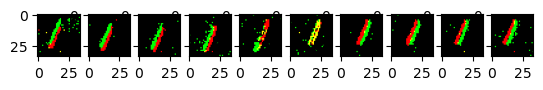

  0%|          | 0/157 [00:00<?, ?it/s]


In [69]:
import matplotlib.pyplot as plt
import torch

ckpt = 'C:\\Users\\qhlzy\\Downloads\\实验2\\runs\\Neuromorphic_T_10_b_64_lr_0.01.pth'#改成你存权重的位置
device = torch.device('cuda:0')
nmnist_net = LIF_2D_CNN()
nmnist_net = torch.load(ckpt, map_location=torch.device('cpu'))
nmnist_net.to(device)

print('输出大小:',net(torch.randn([16,2,20,34,34])).shape)
print(net)

with torch.no_grad():
    for frame, label in tqdm(test_data_loader):
        frame = frame.permute(0,2,1,3,4)
        frame = frame.float().to(device)
        label = label.to(device)
#         label_onehot = F.one_hot(label, 10).float()
        label_onehot = neg_one_hot(label, 10).float()
#         label_onehot = bin_code(label, 10).float()
#         label_onehot = gray_code(label, 10).float()
#         print(label_onehot)
        out_fr = nmnist_net(frame)
#         print(out_fr)
        for t in range(10):
            plt.subplot(1,10,t+1)
            frame_show = frame[0,:,t,...].cpu()
            frame_show = torch.cat([frame_show,torch.zeros(1,34,34)],dim=0)
            frame_show[frame_show>1]=1 
            plt.imshow(frame_show.permute(1,2,0))
#         print('>>>label:',label[0:10,...].cpu().numpy(),'\npredict:',out_fr.argmax(1)[0:10,...].cpu().numpy())
        print('>>>label:',label[0:10,...].cpu().numpy(),'\npredict:',out_fr.argmin(1)[0:10,...].cpu().numpy())
        plt.show()
        break